# 2021 TensorFlow 勉強用

## 手順(1) 機械学習用のdirをマウント

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
ml_dir = "gdrive/MyDrive/mnt_g_colab/colab1/"

In [5]:
import pandas as pd
df_study = pd.read_csv(ml_dir + 'input_sample/ans_studyInput_hp.txt', names=['id', 'truth_val', 'ラベル（教師データ）', '入力'])
df_study

,id,truth_val,ラベル（教師データ）,入力
0,1,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,料金はいくら？
1,2,T,"チャージ料金 1500円また,アルコール類を500円""より提供しております。[こちら](ht...",金額はどのくらいかかる？
2,3,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,いくらあれば足りる？
3,x,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,料金を教えてください
4,x,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,料金について
...,...,...,...,...
171,x,T,成る,物事ができ上がる
172,x,T,成る,実現する
173,x,T,成る,今までと違った状態・形に変わる。
174,x,T,成る,変化・移行した結果が出現する。


## 手順(2) 保存用ディレクトリ、必要なライブラリをインストール

In [6]:
# 入力ファイル用のディレクトリ作成
# !mkdir text
# 必要なライブラリをインストール
!apt-get install mecab libmecab-dev mecab-ipadic-utf8
!pip3 install mecab-python3==0.996.5 tensorflow==2.5.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-jumandic mecab-jumandic-utf8 mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-jumandic
  mecab-jumandic-utf8 mecab-utils
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 29.0 MB of archives.
After this operation, 277 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmecab2 amd64 0.996-5 [257 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmecab-dev amd64 0.996-5 [308 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 mecab-utils amd64 0.996-5 [4,856 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 mecab-jumandic-utf8 all 7.0-20130310-4 [16.2 MB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd6

In [7]:
!pwd
!ls -ltra
!python3 -V

/content
total 20
drwxr-xr-x 4 root root 4096 Dec  3 14:33 .config
drwxr-xr-x 1 root root 4096 Dec  3 14:33 sample_data
drwxr-xr-x 1 root root 4096 Dec 12 01:28 ..
drwx------ 6 root root 4096 Dec 12 05:08 gdrive
drwxr-xr-x 1 root root 4096 Dec 12 05:08 .
Python 3.7.12


In [8]:
!pip freeze
!python --version

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.1.1
chardet==3.0.4
charset-normalizer==2.0.8
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.24
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==1.25.3


In [ ]:
#  !rm ans_studyInput_qa.txt
 # Colaboratoryでファイルをアップロード
 from google.colab import files
 uploaded = files.upload()

Saving ans_studyInput_qa.txt to ans_studyInput_qa.txt


## 手順(4)  学習データ（DB）を作成

In [9]:
import MeCab

# tagger = MeCab.Tagger('mecabrc')
tagger = MeCab.Tagger('-d /etc/alternatives/mecab-dictionary')

def tokenize(text):
    '''MeCabで形態素解析を行う''' # --- (*3)
    result = []
    word_s = tagger.parse(text)
    # print(word_s)
    for n in word_s.split("\n"):
        if n == 'EOS' or n == '': continue
        p = n.split("\t")[1].split(",")
        h, h2, org = (p[0], p[1], p[6])
        if not (h in ['名詞', '動詞', '形容詞']): continue
        if h == '名詞' and h2 == '数': continue
        if org == '*': org = n.split("\t")[0]
        result.append(org)
    # return result
    return ' '.join(result)

In [10]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# csvファイルを読み込む
def main():
    # ファイル一覧を読む --- (*2)　目的により変える！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
    df_study = pd.read_csv(ml_dir + 'input_sample/ans_studyInput_hp.txt', names=['id', 'truth_val', 'ans', 'que'])
    # df_study = pd.read_csv('ans_studyInput_fork.txt', names=['id', 'truth_val', 'ans', 'que'])

    labelToCode = {lbl:idx for idx, lbl in enumerate(df_study.ans.unique())}
    y = df_study.ans.apply(lambda x: labelToCode[x]).tolist()

    # tfidを計算
    df_wakati = df_study["que"].apply(lambda x: tokenize(x))
    vectorizer = TfidfVectorizer(max_df=0.9, token_pattern='(?u)\\b\\w+\\b') # tf-idfの計算 1文字でもOK
    x = vectorizer.fit_transform(df_wakati).toarray()

    # オブジェクト類（tfid等）を保存
    pickle.dump(vectorizer, open(ml_dir + 'text/tfidf_vec.pickle', 'wb'))
    pickle.dump([y, x], open(ml_dir + 'text/genre.pickle', 'wb'))
    pickle.dump(labelToCode, open(ml_dir + 'text/label_to_code.pickle', 'wb'))

    print(df_wakati)

# 実行
if __name__ == '__main__':
    main()

0                 料金 いくら
1                 金額 かかる
2                 ある 足りる
3            料金 教える くださる
4                     料金
             ...        
171             物事 でき上がる
172                実現 する
173        今 違う 状態 形 変わる
174    変化 移行 する 結果 出現 する
175                幸せ なる
Name: que, Length: 176, dtype: object


## 手順(5)  学習モデルを作成

In [11]:
import pickle
import tensorflow as tf

# 分類するラベルの数
labelToCode = pickle.load(open(ml_dir + "text/label_to_code.pickle", "rb"))
nb_classes = len(labelToCode) 

# データベースの読込
data = pickle.load(open(ml_dir + "text/genre.pickle", "rb"))
x = data[1] # TF-IDF

# 入力x[0]の要素数（TF-IDF）より入力要素数を求める
in_size = x[0].shape[0]

# MLPモデル構造を定義
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(in_size,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax))

# モデルをコンパイル
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

input_shape = x.shape
print(input_shape)
# model.build((input_shape)) # `input_shape` is the shape of the input data
#                          # e.g. input_shape = (None, 32, 32, 3)
model.summary()

# モデルを保存する
model.save(ml_dir + 'text/hw_model.h5')
print('model seved')

(176, 238)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               122368    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                15903     
Total params: 400,927
Trainable params: 400,927
Non-trainable params: 0
_________________________________________________________________
model seved


## 手順(6)  学習（MLP）を実行

Epoch 1/300
7/7 [==============================] - 1s 36ms/step - loss: 3.3977 - accuracy: 0.0571 - val_loss: 3.3086 - val_accuracy: 0.1389
Epoch 2/300
7/7 [==============================] - 0s 13ms/step - loss: 3.1670 - accuracy: 0.1786 - val_loss: 3.2002 - val_accuracy: 0.1389
Epoch 3/300
7/7 [==============================] - 0s 9ms/step - loss: 2.9480 - accuracy: 0.3286 - val_loss: 3.0872 - val_accuracy: 0.1667
Epoch 4/300
7/7 [==============================] - 0s 9ms/step - loss: 2.6735 - accuracy: 0.3643 - val_loss: 2.9744 - val_accuracy: 0.3333
Epoch 5/300
7/7 [==============================] - 0s 10ms/step - loss: 2.4080 - accuracy: 0.5214 - val_loss: 2.8192 - val_accuracy: 0.3889
Epoch 6/300
7/7 [==============================] - 0s 9ms/step - loss: 2.1093 - accuracy: 0.6786 - val_loss: 2.6975 - val_accuracy: 0.4722
Epoch 7/300
7/7 [==============================] - 0s 9ms/step - loss: 1.7514 - accuracy: 0.8214 - val_loss: 2.5821 - val_accuracy: 0.4722
Epoch 8/300
7/7 [=======

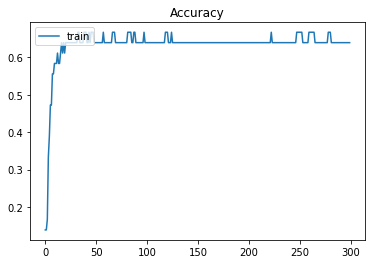

In [12]:
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os


# 分類するラベルの数
labelToCode = pickle.load(open(ml_dir + "text/label_to_code.pickle", "rb"))
nb_classes = len(labelToCode) 

# データベースの読込
data = pickle.load(open(ml_dir + "text/genre.pickle", "rb"))
y = data[0] # ラベルコード
x = data[1] # TF-IDF

# ラベルデータをone-hotベクトルに直す
y = tf.keras.utils.to_categorical(y, nb_classes)
in_size = x[0].shape[0] # 入力x[0]の要素数

# 学習用とテスト用を分ける
x_train, x_test, y_train, y_test = train_test_split(
        np.array(x), np.array(y), test_size=0.2)

# モデルを読み込む
model = tf.keras.models.load_model(ml_dir + 'text/hw_model.h5')

# 既に学習済みの重みデータが存在していれば読み込む
# if os.path.exists(ml_dir + 'text/hw_weights.h5'):
#     model.load_weights(ml_dir + 'text/hw_weights.h5')

# 学習を実行
hist = model.fit(x_train, y_train,
          batch_size=20, # 1回に計算するデータ数
          epochs=300,    # 学習の繰り返し回数みたいなもの
          verbose=1,
          validation_data=(x_test, y_test))

# 評価する
score = model.evaluate(x_test, y_test, verbose=1)
print("正解率=", score[1], 'loss=', score[0])

# 重みデータを保存
model.save_weights(ml_dir + 'text/hw_weights.h5')

# 学習の様子をグラフへ描画
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 手順(7)  学習（MLP）モデルを実行して、判定

In [13]:
import pickle
import tensorflow as tf


def inverse_dict(d):
    return {v:k for k,v in d.items()}

# モデルを読み込む
model = tf.keras.models.load_model(ml_dir + 'text/hw_model.h5')
# 学習済みの重みデータを読み込む
model.load_weights(ml_dir + 'text/hw_weights.h5')
# tfidオブジェクトをファイルよりロードする
vectorizer_loaded = pickle.load(open(ml_dir + "text/tfidf_vec.pickle", "rb"))
# ラベルの定義
labelToCode = pickle.load(open(ml_dir + "text/label_to_code.pickle", "rb"))
label_dic = inverse_dict(labelToCode)

# テキストを指定して判定
def getMusicName(text):
    # TF-IDFのベクトルに変換 
    data = vectorizer_loaded.transform([tokenize(text)]).toarray()
    # MLPで予測
    pre = model.predict(data)[0]
    sortIndexDesc = pre.argsort()[::-1];
    for no, ind in enumerate(sortIndexDesc, 1):
        print(f"{no}番目の答え: {label_dic[ind]}({pre[ind]:.4f})")
        if no == 5: break

    # n = pre.argmax()
    # print("一番目の答え : " + label_dic[n], "(", pre[n], ")")
    # # 2番以降
    # # desc_sort_list = pre.argsort()[::-1]
    # n_second = pre.argsort()[-2]
    # print("2番目の答え : " + label_dic[n_second], "(", pre[n_second], ")")

if __name__ == '__main__':
    # requestParam = """
    # 出会いに関しての歌で、中島みゆきさんが歌う
    # """
    requestParam = """
    知識をたくさん付けて選択肢を増やす
    """
    getMusicName(requestParam)

1番目の答え: 幸福(0.8376)
2番目の答え: 人間(0.1618)
3番目の答え: [ユーチューブチャンネル](https://www.youtube.com/channel/UCJqq9wYdNCzzuRvAeI_Op7Q)、[facebook](https://www.facebook.com/toshihiro.suzuki.796)を開設しております。(0.0002)
4番目の答え: 近況はトップページに載せております。どうぞよろしくお願いします。[近況はこちら](https://nango7.okbmk.com/nango)(0.0001)
5番目の答え: 成る(0.0001)


In [14]:
getMusicName(
    # """
    # 感情に惑わされず、好奇心をもって知識をたくさん付けて選択肢を増やすし、健康体を実現する
    # """
    """
    美味しい朝ご飯を食べる
    """
)

1番目の答え: 人間(1.0000)
2番目の答え: [ユーチューブチャンネル](https://www.youtube.com/channel/UCJqq9wYdNCzzuRvAeI_Op7Q)、[facebook](https://www.facebook.com/toshihiro.suzuki.796)を開設しております。(0.0000)
3番目の答え: 不幸(0.0000)
4番目の答え: お褒めの言葉、大変ありがとうございます。是非お越しください！！！！(0.0000)
5番目の答え: 予約可能です。10～30名様でご利用いただけるお得な貸切プランを各種ご用意しております。詳細は[こちら](https://nango7.okbmk.com/nango/rt/party_nango_temp)(0.0000)


In [15]:
import pickle
import tensorflow as tf
import pandas as pd


def inverse_dict(d):
    return {v:k for k,v in d.items()}

# モデルを読み込む
model = tf.keras.models.load_model(ml_dir + 'text/hw_model.h5')
# 学習済みの重みデータを読み込む
model.load_weights(ml_dir + 'text/hw_weights.h5')
# tfidオブジェクトをファイルよりロードする
vectorizer_loaded = pickle.load(open(ml_dir + "text/tfidf_vec.pickle", "rb"))
# ラベルの定義
labelToCode = pickle.load(open(ml_dir + "text/label_to_code.pickle", "rb"))
label_dic = inverse_dict(labelToCode)

# テキストを指定して判定
def predCatego(text):
    # TF-IDFのベクトルに変換 
    data = vectorizer_loaded.transform([tokenize(text)]).toarray()
    # MLPで予測
    pre = model.predict(data)[0]
    sortIndexDesc = pre.argsort()[::-1];
    catList = []
    catDic = {}
    for no, ind in enumerate(sortIndexDesc, 1):
        # catList.append({label_dic[ind]: pre[ind]})
        catDic[label_dic[ind]] = pre[ind]
        if no == 4: break

    return catDic

def showPred(text):
    data = vectorizer_loaded.transform([tokenize(text)]).toarray()
    pre = model.predict(data)[0]
    sortIndexDesc = pre.argsort()[::-1];
    for no, ind in enumerate(sortIndexDesc, 1):
        print(f"{no}番目の答え: {label_dic[ind]}({pre[ind]:.4f})")
        if no == 7: break

def isTrgText(text):
    trgCatList = ["人間", "幸福", "成る"]
    untiTrgCatList = ["不幸"]
    predDic = predCatego(text);

    return isInTrg(text, trgCatList, untiTrgCatList, predDic)

def isInTrg(text, trgCatList, untiTrgCatList, predDic):
    thVal = 0.2
    for trg in trgCatList:
        if trg not in predDic: return False
        if predDic[trg] < thVal: return False

    for uTrg in untiTrgCatList:
        if uTrg in predDic: return False
    
    return True

if __name__ == '__main__':
    requestParam = """
    知識をたくさん付けて選択肢を増やす
    """
    predCatego(requestParam)

In [55]:
isTrgText(
    """
    苦しみに耐え、知恵をしぼり、おいしいものを食べ、幸せと発する
    """
)

True

In [60]:
import pandas as pd
import itertools


limit_cnt = 20000;
act_list = ['苦悩', '耐える', '発する', '知恵', '知ること', '好奇心', '食べる', '選択肢', '増える', 'テレビ', '美味しい'
 , '飛行機', '実現する', '良い', 'パートナー', '思い', '込み',  '道具', '作り', '瞑想', '存在', '採集', '狩猟', 'する', '朝ご飯', '幸せ'
 , '睡眠', '役立つ', '人', '言動']

cnt = 1
for wc in range(3, 7):
    comb_list = list(itertools.combinations(act_list, wc))
    for comb in comb_list:
        text = ','.join(comb)
        print(f"\r計算回数: {cnt}", end='')
        # print(f"文章: {text}")
        if isTrgText(text):
            print(f"\n該当文章: {text}")
            showPred(text)
        cnt += 1
        if cnt > limit_cnt: break
    else:
        continue
    break

計算回数: 527
該当文章: 耐える,食べる,幸せ
1番目の答え: 人間(0.4146)
2番目の答え: 幸福(0.3513)
3番目の答え: 成る(0.2320)
4番目の答え: お褒めの言葉、大変ありがとうございます。是非お越しください！！！！(0.0005)
5番目の答え: [ユーチューブチャンネル](https://www.youtube.com/channel/UCJqq9wYdNCzzuRvAeI_Op7Q)、[facebook](https://www.facebook.com/toshihiro.suzuki.796)を開設しております。(0.0004)
6番目の答え: いらっしゃいます、、、当店は初めての方でも、気楽に楽しいひと時をモットーにしております。是非、お気軽にお越しください。(0.0003)
7番目の答え: 予約可能です。10～30名様でご利用いただけるお得な貸切プランを各種ご用意しております。詳細は[こちら](https://nango7.okbmk.com/nango/rt/party_nango_temp)(0.0002)
計算回数: 733
該当文章: 耐える,瞑想,する
1番目の答え: 成る(0.3004)
2番目の答え: 幸福(0.2180)
3番目の答え: 人間(0.2100)
4番目の答え: どなたでもカラオケ感覚で歌って演奏できます。お店の楽器は自由に演奏できます。また、視聴のみでもゆったりして頂ければと思います。(0.0987)
5番目の答え: 予約可能です。10～30名様でご利用いただけるお得な貸切プランを各種ご用意しております。詳細は[こちら](https://nango7.okbmk.com/nango/rt/party_nango_temp)(0.0950)
6番目の答え: [ユーチューブチャンネル](https://www.youtube.com/channel/UCJqq9wYdNCzzuRvAeI_Op7Q)、[facebook](https://www.facebook.com/toshihiro.suzuki.796)を開設しております。(0.0208)
7番目の答え: お褒めの言葉、大変ありがとうございます。是非お越しください！！！！(0.0187)
計算回数: 1084
該当文章: 発する,瞑想

## 手順(8)  デプロイに必要な学習済みデータをダウンロード

In [ ]:
! zip -r res /content/gdrive/MyDrive/mnt_g_colab/text/
from google.colab import files
files.download('res.zip')

updating: text/ (stored 0%)
updating: text/genre.pickle (deflated 97%)
updating: text/genre-model.hdf5 (deflated 9%)
updating: text/genre-tdidf.dic (deflated 41%)
updating: text/label_to_code.pickle (deflated 64%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>